# Data Augmentation

### Modules and Libraries

In [ ]:
import os
import random
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf
import seaborn as sns
from glob import glob

In [2]:
def count_files_in_folder(folder_path):
    """
    Counts the number of audio files in each subfolder of the given folder.
    """

    data = []
    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path)])  # Filter audio files
            data.append({'Label': class_name, 'Count': count})

            # print(class_name, count)

    return pd.DataFrame(data)
    

In [3]:
def plot_distribution(df, title):
    """Plot the distribution of audio files in each class."""

    plt.figure(figsize=(12, 8))

    ax = sns.barplot(data=df, x='Label', y='Count', legend=False, color='cornflowerblue')

    # Add title and labels
    plt.title(title, fontsize=12)
    plt.xlabel('Class', fontsize=10)
    plt.ylabel('Number of Audio Files', fontsize=10)

    # Adjust font size and rotation for better readability
    plt.xticks(fontsize=8, rotation=90)
    plt.yticks(fontsize=8)

    # Add count above the bars
    for bar in ax.patches:
        ax.annotate(f'{int(bar.get_height())}', 
                    (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                    ha='center', va='bottom', fontsize=8)

    plt.savefig(f'{title}.png', bbox_inches='tight')
    plt.tight_layout()
    plt.show()

### Data Distribution Before Augmentation

In [4]:
DATASET_PATH = './dataset'

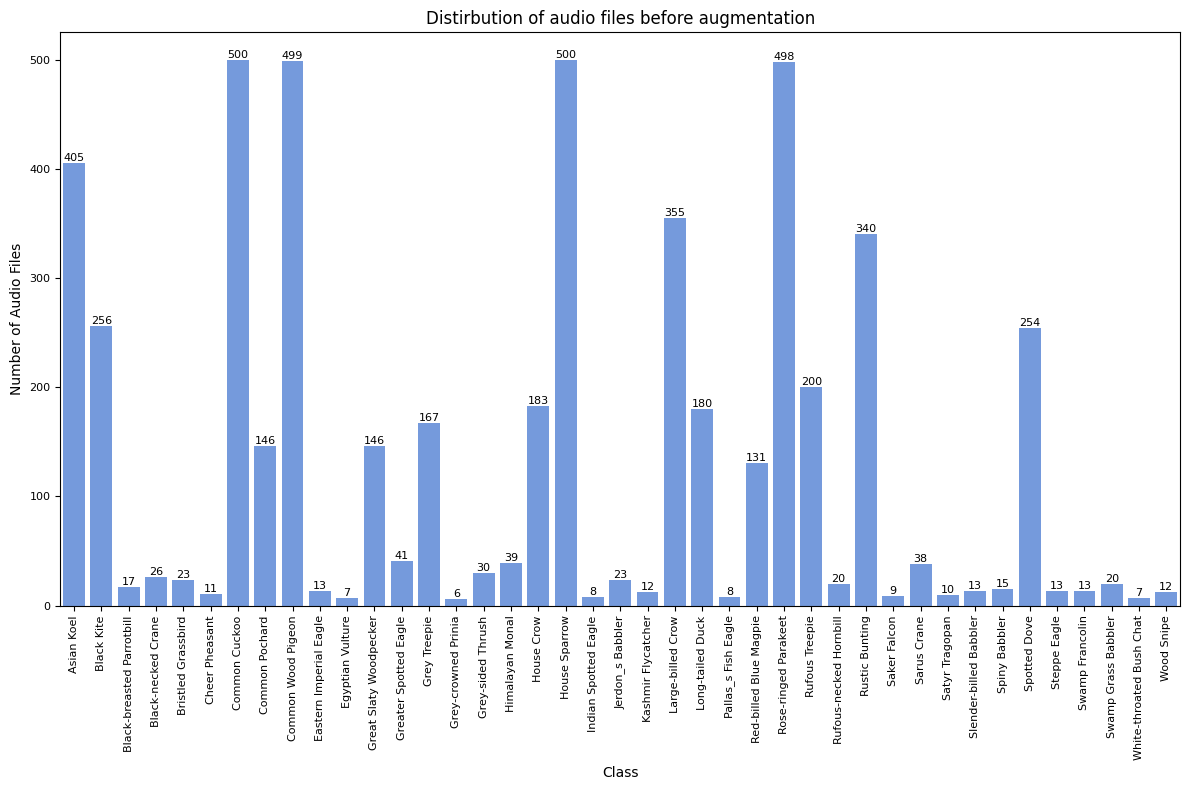

In [5]:
count_df = count_files_in_folder(DATASET_PATH)
plot_distribution(count_df, 'Distribution of audio files before augmentation')

### Data Augmentation

In [7]:
SAMPLE_RATE = 22050
DURATION = 10
MIN_DURATION = 5
TARGET_COUNT = 500
OUTPUT_DIR = './augmented_data'

In [11]:
def split_audio(audio, sr, target_duration=DURATION, min_duration=MIN_DURATION):
    """Split audio into 10-second segments, ignoring segments shorter than 3 seconds."""
    
    target_length = target_duration * sr
    min_length = min_duration * sr
    audio_splits = []
    
    # Iterate in chunks of 10 seconds
    for start in range(0, len(audio), target_length):
        split_audio = audio[start:start + target_length]
        
        if len(split_audio) >= min_length:  # Ignore if less than 3 seconds
            if len(split_audio) < target_length:
                # Calculate the average value of the existing audio samples for padding
                avg_value = np.mean(split_audio) if len(split_audio) > 0 else 0
                padding_length = target_length - len(split_audio)
                
                # Pad with the average value of the audio if less than 10 seconds
                split_audio = np.pad(split_audio, (0, padding_length), mode='constant', constant_values=avg_value)
            
            audio_splits.append(split_audio)
    
    return audio_splits

In [12]:
def augment_audio(audio, sr):
    """Apply random augmentation like pitch shift, time stretch, and noise addition."""
    
    # Time stretch
    if np.random.random() < 0.5:
        rate = np.random.uniform(0.8, 1.2)  # Stretch between 80% and 120%
        audio = librosa.effects.time_stretch(audio, rate=rate)
    
    # Pitch shift
    if np.random.random() < 0.5:
        n_steps = np.random.randint(-2, 3)  # Shift pitch between -2 and +2 semitones
        audio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)
    
    # Add noise
    if np.random.random() < 0.5:
        noise_amp = 0.005 * np.random.uniform() * np.amax(audio)
        audio = audio + noise_amp * np.random.normal(size=audio.shape)
    
    # Clip to 10 seconds
    audio = clip_audio(audio, sr)
    
    return audio

In [13]:
def clip_audio(audio, sr, target_duration=DURATION):
    """Clip or pad audio to the target duration."""
    target_length = target_duration * sr
    
    if len(audio) > target_length:
        return audio[:target_length]
    
    elif len(audio) < target_length:
        padding_length = target_length - len(audio)
        return np.pad(audio, (0, padding_length), mode='constant')
    
    return audio

In [14]:
def save_audios(class_path, audios, sr, prefix="sample"):
    """Save audio files to the output directory based on class path."""
    class_name = os.path.basename(class_path)
    out_path = os.path.join(OUTPUT_DIR, class_name)
    os.makedirs(out_path, exist_ok=True)
    
    for i, audio in enumerate(audios):
        out_file = os.path.join(out_path, f"{prefix}_{i}.wav")
        sf.write(out_file, audio, sr)

In [15]:
def process_class(class_path, sr=SAMPLE_RATE):
    """Process a class folder by splitting and augmenting audio files."""
    files = glob(os.path.join(class_path, "*"))
    all_splits = []

    # Split all audio files into 10-second segments
    for file_path in files:
        # print(file_path)
        audio, _ = librosa.load(file_path, sr=sr)
        splits = split_audio(audio, sr)
        all_splits.extend(splits)

    # Downsample if more than 500 segments
    if len(all_splits) > TARGET_COUNT:
        all_splits = random.sample(all_splits, TARGET_COUNT)
    save_audios(class_path, all_splits, sr)

    # If fewer than 500, augment to reach target
    augmented_audios = []
    while len(all_splits) + len(augmented_audios) < TARGET_COUNT:
        idx = np.random.randint(0, len(all_splits))
        augmented_audio = augment_audio(all_splits[idx], sr)
        augmented_audios.append(augmented_audio)

    # Save augmented audio samples
    save_audios(class_path, augmented_audios, sr, prefix="augmented")

In [16]:
def process_dataset(dataset_path):
    """Process the entire dataset by splitting and augmenting each class folder."""
    class_folders = [os.path.join(dataset_path, class_name) for class_name in os.listdir(dataset_path)]
    
    for class_folder in class_folders:
        if os.path.isdir(class_folder):
            print(f"Processing {class_folder}...")
            process_class(class_folder)

In [ ]:
process_dataset(DATASET_PATH)

### Data Distribution After Augmentation

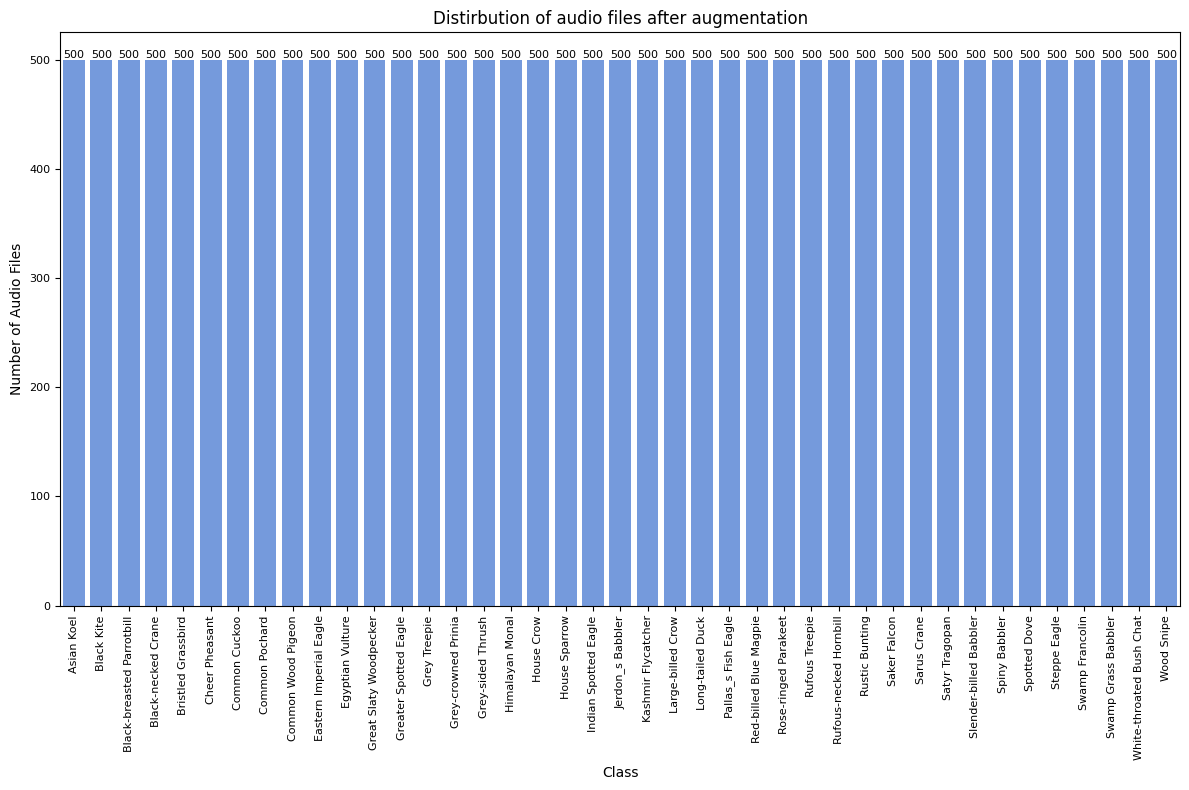

In [19]:
count_df = count_files_in_folder(OUTPUT_DIR)
plot_distribution(count_df, 'Distirbution of audio files after augmentation')